# Machine Learning in sklearn: Data Exploration and Model Fitting

This notebook demonstrates a potential workflow for data exploration and Machine Learning model creation in Python using *sklearn*.

## Data Exploration

This section contains several methods for the descriptive statistical analysis of datasets.
Purpose: exploration and preparation of data for modeling.

The script loads the Boston House Prices dataset from the *sklearn* package per default.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load demo dataset
from sklearn.datasets import load_boston
dataset = load_boston()

## First check of data
*Print dataset description (only if available):*

In [3]:
if hasattr(dataset, 'DESCR'):
    print(dataset['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

*Convert dataset to Pandas DataFrame (DF), add target data as new column, and check DF head:*

In [4]:
data_df = pd.DataFrame(data=dataset['data'])
if hasattr(dataset, 'feature_names'):
    data_df.columns=dataset['feature_names']
else:
    print("Please specify the feature names manually!")
data_df['TARGET'] = dataset['target']
print(data_df.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  TARGET  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


*Print DF statistics:*
- distribution of data
- sample count
- type of data

In [5]:
data_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
TARGET     506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


*Count null values per feature:*

In [7]:
# count null values per feature:
print(data_df.isnull().sum())

# drop null values if present:
unprocessed_length = len(data_df)
data_df = data_df.dropna()
processed_length = len(data_df)
print(f"\nUnprocessed DF length: {unprocessed_length}, processed DF length: {processed_length}, dropped instances: {unprocessed_length - processed_length}.")

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
TARGET     0
dtype: int64

Unprocessed DF length: 506, processed DF length: 506, dropped instances: 0.


*Correlation/distribution preview:*

Plot Scatter Matrix of Data:

<Figure size 432x288 with 0 Axes>

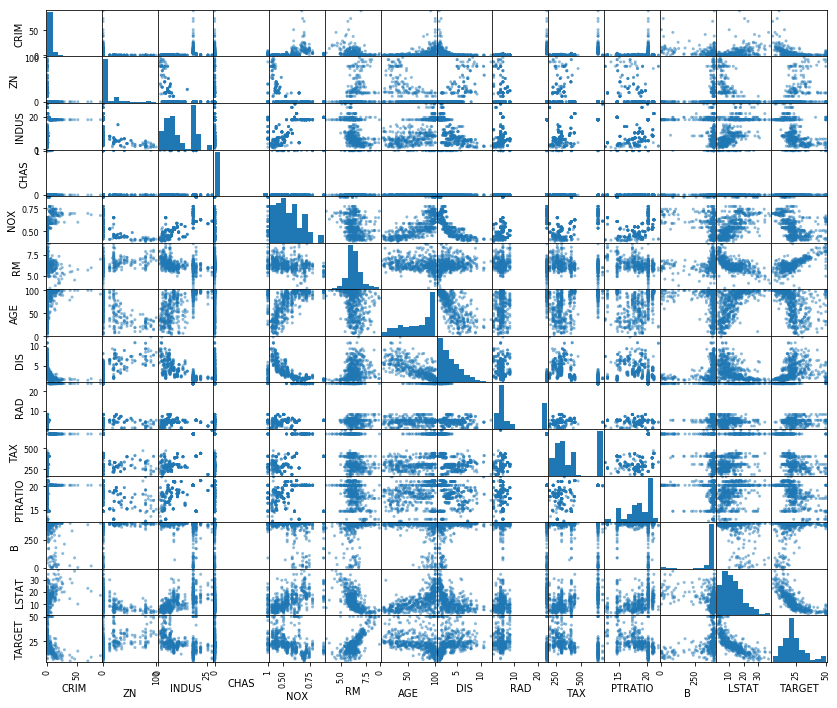

In [8]:
fig = plt.figure()
pd.plotting.scatter_matrix(data_df, figsize=((14, 12)))
plt.show()

*Create correlation matrix and plot it as a heatmap:*
- highly (positively or negatively) correlated features may contain redundant information - potential targets for removal for more efficient modeling / predictions
- desired: features with a high correlation to the target

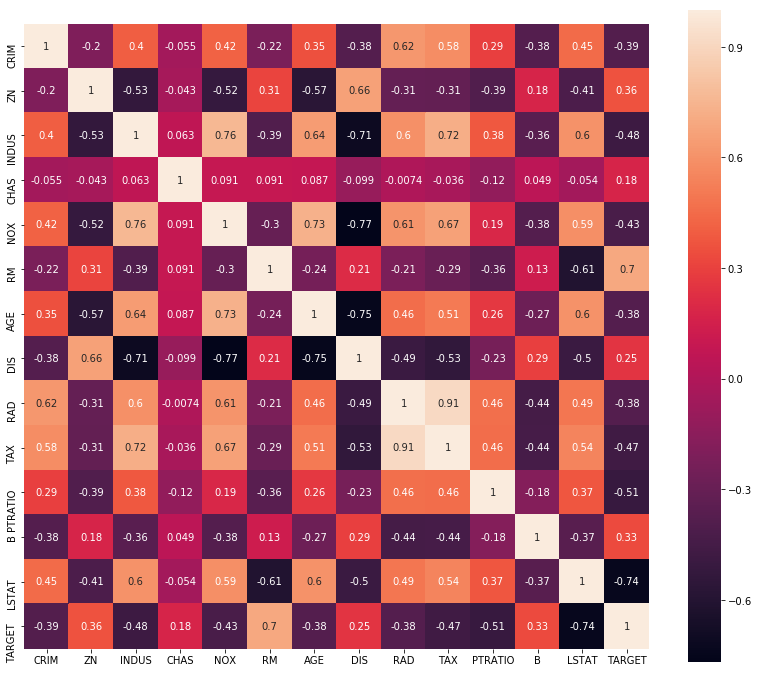

In [9]:
corr = data_df.corr()
fig = plt.figure(figsize=(14, 12))
sns.heatmap(corr, square=True, annot=True)  # switch off annot to hide values
plt.show()

*Plot distribution information:*

Issues with the distribution may lead to problems during model fitting. This may be compensated by data transformation and/or under-/oversampling of data.

- a) box and whisker plot
- b) histograms

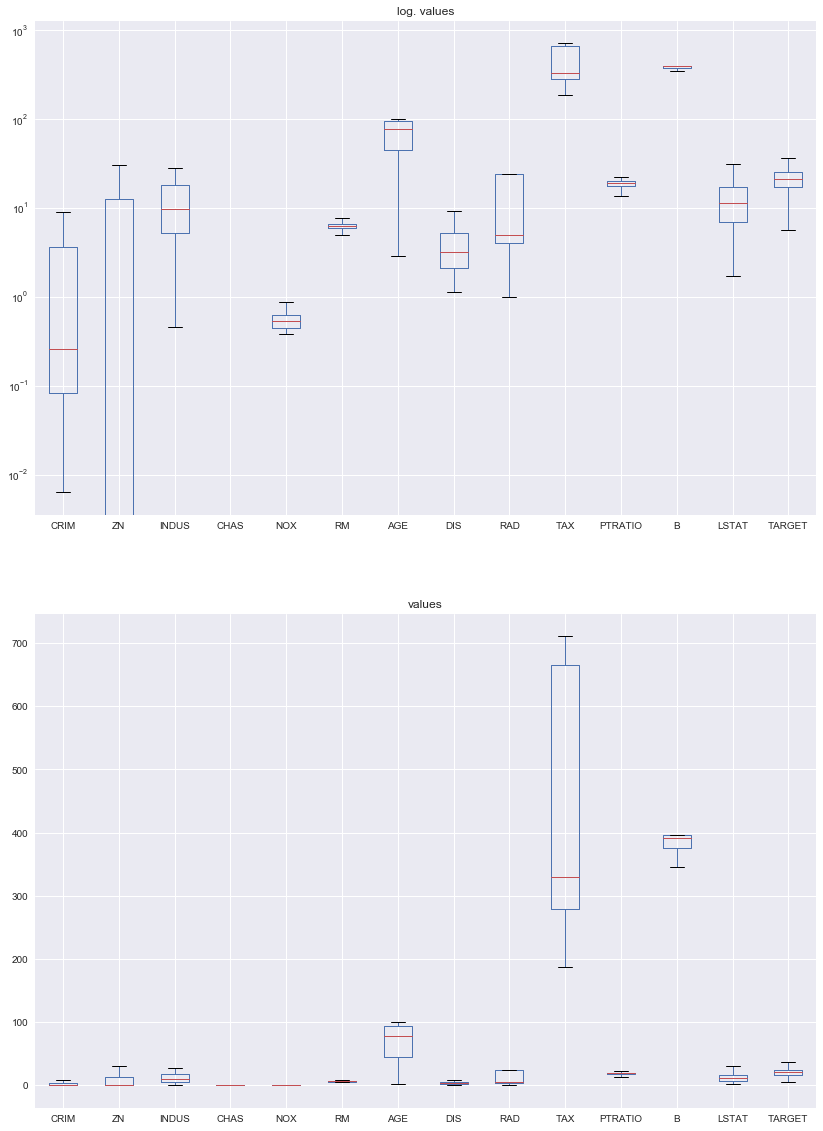

In [20]:
# a) box and whisker plot
sns.set()  # use Seaborn Standard Formatting from here on

fig, ax = plt.subplots(2, 1)
data_df.plot(kind='box', logy=True, figsize=(14,20), ax=ax[0], title='log. values')
data_df.plot(kind='box', logy=False, figsize=(14,20), ax=ax[1], title='values')
plt.show()

<Figure size 432x288 with 0 Axes>

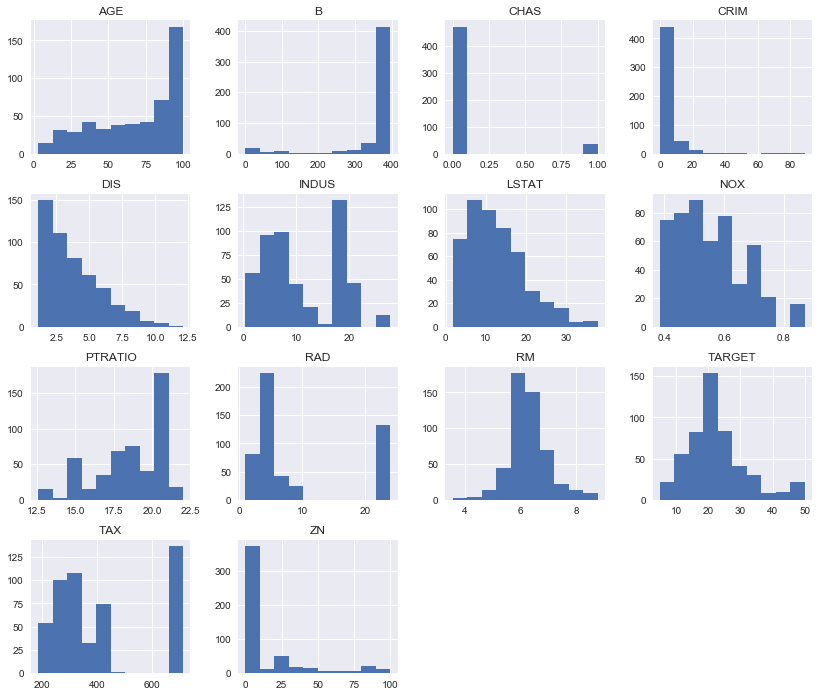

In [21]:
# b) histograms
fig = plt.figure()
data_df.hist(figsize=(14, 12))
plt.show()

*No actions will be performed on the dataset in this demonstration.*

## Data preprocessing, model creation, and model fit

The following steps create the actual model and fit it to the data. The workflow assumes that the target is numeric, i.e., Regressor Models will be used for the fit.

Two models will be used:
- Random Forest Regressor (i.e., an ensemble of multiple Decision Trees)
- K-nearest Neighbors Regressor

In [12]:
# import scikit learn packages:
# data preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# models:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsRegressor as KNR

*Shuffle the DataFrame and split it into 20% Test Set and 80% Training Set.*

In [13]:
data_df = shuffle(data_df)
train_df, test_df = train_test_split(data_df, test_size=0.2)

# split dataframes into features and targets:
if hasattr(dataset, 'feature_names'):
    train_data = train_df[dataset['feature_names']]
    test_data = test_df[dataset['feature_names']]
else:
    print("Please provide the feature names manually!")
    
train_target = train_df['TARGET']
test_target = test_df['TARGET']

# create dictionary for the results of fitting and scoring:
res_dict = {}

*Creation of and fit to the Random Forest Regressor:*

In [14]:
# screening parameters - in this demonstration, the number of estimators and the tree depth will be varied:
n_estimators = [20, 50, 100]
max_depths = [2, 5, 10, 20]

for n_est in n_estimators:
    for max_dep in max_depths:
        current_identifier = f"RFR model (n_estimators: {n_est}, max_depth: {max_dep})"
        RFR_model = RFR(n_estimators=n_est, max_depth=max_dep)
        RFR_model.fit(train_data, train_target)
        train_score = RFR_model.score(train_data, train_target)
        test_score = RFR_model.score(test_data, test_target)
        res_dict[current_identifier] = {'model': RFR_model, 'train score': train_score, 'test score': test_score}

*Creation of and fit to the K-nearest Neighbors Regressor:*

In [15]:
# screening parameters - in this demonstration, only the number of neighbors will be varied:
n_neighbors = [2, 3, 5, 10]

for n_n in n_neighbors:
    current_identifier = f"KNR model (n_neighbors: {n_n})"
    KNR_model = KNR(n_neighbors=n_n)
    KNR_model.fit(train_data, train_target)
    train_score = KNR_model.score(train_data, train_target)
    test_score = KNR_model.score(test_data, test_target)
    res_dict[current_identifier] = {'model': KNR_model, 'train score': train_score, 'test score': test_score}

*Iterate through results dictionary and create a results DataFrame:*

In [16]:
res_df = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score'])

for key, value in res_dict.items():
    res_df = res_df.append({'Model': key,
                            'Test Score': round(res_dict[key]['test score'], 2),
                            'Train Score': round(res_dict[key]['train score'], 2)}, ignore_index=True)

# sort values by Test Score in descending order:
res_df.sort_values(by='Test Score', ascending=False, inplace=True)
res_df.reset_index(drop=True, inplace=True)

# print results:
print(res_df)

                                           Model  Train Score  Test Score
0    RFR model (n_estimators: 50, max_depth: 10)         0.97        0.84
1    RFR model (n_estimators: 50, max_depth: 20)         0.98        0.84
2   RFR model (n_estimators: 100, max_depth: 10)         0.98        0.84
3    RFR model (n_estimators: 20, max_depth: 20)         0.98        0.83
4   RFR model (n_estimators: 100, max_depth: 20)         0.98        0.83
5    RFR model (n_estimators: 20, max_depth: 10)         0.97        0.82
6    RFR model (n_estimators: 100, max_depth: 5)         0.94        0.82
7     RFR model (n_estimators: 50, max_depth: 5)         0.94        0.81
8     RFR model (n_estimators: 20, max_depth: 5)         0.94        0.80
9     RFR model (n_estimators: 20, max_depth: 2)         0.77        0.67
10    RFR model (n_estimators: 50, max_depth: 2)         0.77        0.67
11   RFR model (n_estimators: 100, max_depth: 2)         0.77        0.66
12                    KNR model (n_nei

### Feature Importance:

*Create a plot of the Feature Importance based on the best-performing Random Forest Regressor:*

The Feature Importance denotes the proportion of the Target determined by the respective Feature.

<Figure size 432x288 with 0 Axes>

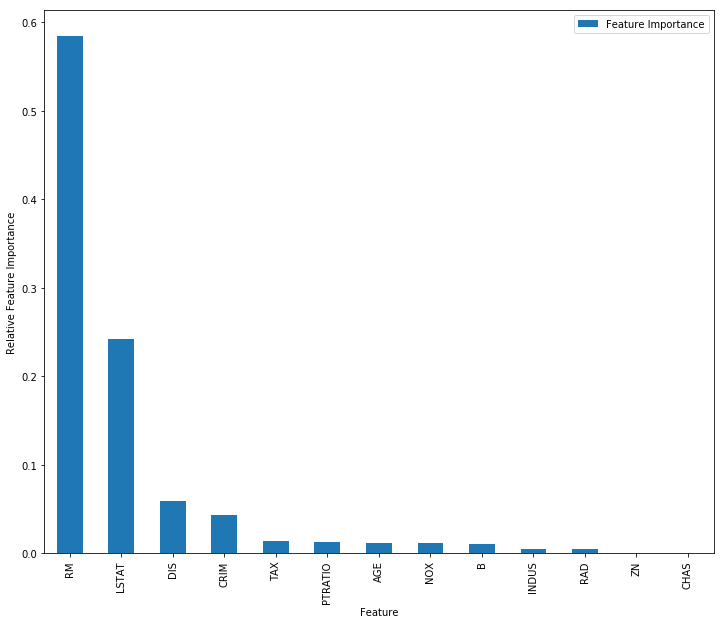

DataFrame of Feature Importance:

          Feature Importance
RM                 0.584762
LSTAT              0.242636
DIS                0.058722
CRIM               0.043035
TAX                0.013899
PTRATIO            0.012934
AGE                0.011582
NOX                0.011311
B                  0.010221
INDUS              0.004902
RAD                0.004486
ZN                 0.000834
CHAS               0.000676


In [17]:
# isolate identifier of best-performing Random Forest Regressor model:
for ind, row in res_df.iterrows():
    if 'RFR model' in row['Model']:
        identifier = row['Model']
        break

# isolate feature importances from model and create dictionary based on these values:
feature_imp_dict = dict(zip(dataset['feature_names'], res_dict[identifier]['model'].feature_importances_))
# convert dictionary to DataFrame:
imp_df = pd.DataFrame.from_dict(data=feature_imp_dict, orient='index')
imp_df.columns = ['Feature Importance']

# sort values in descending order:
imp_df.sort_values(by='Feature Importance', inplace=True, ascending=False)

# create plot:
fig = plt.figure()
imp_df.plot.bar(figsize=(12, 10))
plt.ylabel('Relative Feature Importance')
plt.xlabel('Feature')
plt.show()

# print Feature Importance DataFrame:
print("DataFrame of Feature Importance:\n\n", imp_df)

### Use the best-performing model for predictions:

In [18]:
# load model and print model properties:
best_model = res_dict[res_df.iloc[0]['Model']]['model']
print(f"Best-performing model: {res_df.iloc[0]['Model']}.\nModel properties:\n {best_model}")

Best-performing model: RFR model (n_estimators: 50, max_depth: 10).
Model properties:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [19]:
# using the best-performing model for predictions:
# use first DF row as demo test dataset; replace this row by actual data for real predictions
test_dataset = np.array(data_df.iloc[0][:-1].values.reshape(1, -1))  
prediction = best_model.predict(test_dataset)  # provide data in form of an array
print(f"Features:\n{test_dataset}\n\n Model prediction: {prediction[0]}")

Features:
[[1.1329e-01 3.0000e+01 4.9300e+00 0.0000e+00 4.2800e-01 6.8970e+00
  5.4300e+01 6.3361e+00 6.0000e+00 3.0000e+02 1.6600e+01 3.9125e+02
  1.1380e+01]]

 Model prediction: 24.674373798627002
